# Part 2: Country recommender using World Bank data in Python
Janos Perge

###Approach:

For each country, calculate a Country Preference Score, i.e. a weighted sum of selected indicators.
  
This means:  
1) select country indicators and  
2) assign importance scores for those indicators.  
  
As indicator values were occasionally missing in certain years, I calculated the average value over the past five years.
   
Country Preference Score = indicator1 x score1 + indicator2 x score2 .... indicatorEnd x scoreEnd

Finally, plot 30 countries with the highest preference scores

## Import Python libraries

In [1]:
%matplotlib inline

import wbdata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py

## Select relevant indicators

I explored indicators using methods such as:
wbdata.get_source(), 
wbdata.get_indicator(source=2), or 
wbdata.search_indicators("gdp per capita, ppp")

Here are the results:

In [2]:
# INPUT PARAMETERS

indicators     = {'SP.DYN.LE00.IN': 'Life expectancy',
                  'SH.DTH.COMM.ZS': 'dye from disease',
                  'SH.DTH.INJR.ZS': 'dye from injury',                
                  'SP.DYN.CDRT.IN': 'crude death rate/1000pers',                  
                  'EN.ATM.CO2E.PC': 'CO2 emission/capita',
                  'NY.GDP.PCAP.PP.CD': 'GDP',
                  'SL.UEM.TERT.ZS': 'unemployment tertiary',
                  'SL.UEM.SECO.ZS': 'unemployment secondary',
                  'SL.EMP.TOTL.SP.NE.ZS': 'employed ratio (+15yo)'}

subjPreference = {'Life expectancy': 1,
                  'dye from disease': -1,
                  'dye from injury': -1,
                  'crude death rate/1000pers':-.6,
                  'CO2 emission/capita': -.4,

                  'GDP': .9,
                  'unemployment tertiary': -.9,
                  'unemployment secondary': -.5,
                  'employed ratio (+15yo)': -.3}

yearLow        = 2010
yearHigh       = 2015

## Obtain country codes and names

In [3]:
#obtain country codes and regional metadata:
countryInfo = wbdata.get_country(country_id=None, display=False)
dfInfo = pd.DataFrame(countryInfo)

#obtain dataframe of country codes that are real countries and not aggregates:
ccodes = [];
cnames = [];
for i in range(len(dfInfo)):
    if str(dfInfo['region'][i]['value'])  != 'Aggregates':
        ccodes.append(dfInfo['id'][i])
        cnames.append(dfInfo['name'][i])
dfM = pd.DataFrame(ccodes, index=cnames, columns=['id'])
dfM.index.name = 'country'
dfM.head()

,id
country,
Aruba,ABW
Afghanistan,AFG
Angola,AGO
Albania,ALB
Andorra,AND


In [4]:
# GIVEN THE LIST OF COUNTRY CODES, YEARS AND INDICATORS, ADD DATA COLUMNS TO dfM:
#indicator format = {indicatorCode:indicatorLabel} 
data_date = (datetime.datetime(yearLow, 1, 1), datetime.datetime(yearHigh, 12, 1)) 

for measure, label in indicators.items():
    df = wbdata.get_dataframe({measure: label}, country = ccodes, data_date=data_date, convert_date=False, keep_levels=False)
    # average across the last five years of data (to also deal with missing values):
    ind = df.groupby(level=0).mean()        
    dfM[label] = ind

dfM.head()

,id,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy
country,,,,,,,,,,
Aruba,ABW,24.052557,36015.070460,NaN,8.13175,NaN,NaN,NaN,NaN,75.142835
Afghanistan,AFG,0.364099,1831.702129,NaN,8.24975,NaN,17.4,46.0,NaN,60.276500
Angola,AGO,1.377831,6790.368992,NaN,14.38325,NaN,9.5,66.4,NaN,51.260915
Albania,ALB,1.561335,9791.736557,NaN,6.75575,NaN,5.5,5.1,49.975,77.257360
Andorra,AND,6.046728,NaN,NaN,3.35000,NaN,NaN,NaN,NaN,NaN


In [9]:
# NORMALIZE DATA TO BRING DIFFERENT INDICATORS INTO THE SAME SCALE
df = dfM
for label in indicators.values():
    df[label] = (df[label] - df[label].min())
    df[label] = df[label]/df[label].max()
df.head()

,id,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy,Preference Score
country,,,,,,,,,,,
Aruba,ABW,0.445101,0.261039,NaN,0.570596,NaN,NaN,NaN,NaN,0.783238,0.538571
Afghanistan,AFG,0.992076,0.008658,NaN,0.563433,NaN,0.683036,0.377095,NaN,0.394298,-0.802888
Angola,AGO,0.968669,0.045269,NaN,0.191119,NaN,0.859375,0.092179,NaN,0.158428,-1.347137
Albania,ALB,0.964432,0.067428,NaN,0.654122,NaN,0.948661,0.948324,0.599095,0.838559,0.454204
Andorra,AND,0.860862,NaN,NaN,0.860857,NaN,NaN,NaN,NaN,NaN,-0.139141


In [6]:
#APPLY SUBJECTIVE PREFERENCE SCORE FOR EACH INDICATOR AND REARRANGE COLUMNS FOR BETTER VISIBILITY
for label, score in subjPreference.items():    
    df[label] = df[label]*score    

df['Preference Score']= df.sum(axis = 1)
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index('Preference Score')))
df = df.reindex(columns= cols)
df.head()

,id,Preference Score,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy
country,,,,,,,,,,,
Aruba,ABW,0.538571,-0.221960,0.234935,NaN,-0.257642,NaN,NaN,NaN,NaN,0.783238
Afghanistan,AFG,-0.802888,-0.003169,0.007792,NaN,-0.261940,NaN,-0.316964,-0.622905,NaN,0.394298
Angola,AGO,-1.347137,-0.012532,0.040742,NaN,-0.485328,NaN,-0.140625,-0.907821,NaN,0.158428
Albania,ALB,0.454204,-0.014227,0.060685,NaN,-0.207527,NaN,-0.051339,-0.051676,-0.120271,0.838559
Andorra,AND,-0.139141,-0.055655,NaN,NaN,-0.083486,NaN,NaN,NaN,NaN,NaN


In [7]:
#DISCARD COUNTRIES WITH MULTIPLE MISSING DATA (allow max 3 missing indicators)
totalCols = len(df.columns)
minRequiredIndicator = totalCols - 4
ii = df.count(axis=1) > minRequiredIndicator
dff = df.loc[ii, :]
dff.head()

,id,Preference Score,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy
country,,,,,,,,,,,
Afghanistan,AFG,-0.802888,-0.003169,0.007792,NaN,-0.261940,NaN,-0.316964,-0.622905,NaN,0.394298
Angola,AGO,-1.347137,-0.012532,0.040742,NaN,-0.485328,NaN,-0.140625,-0.907821,NaN,0.158428
Albania,ALB,0.454204,-0.014227,0.060685,NaN,-0.207527,NaN,-0.051339,-0.051676,-0.120271,0.838559
United Arab Emirates,ARE,0.449146,-0.187092,0.397608,NaN,-0.000000,NaN,-0.448661,-0.141061,NaN,0.828352
Argentina,ARG,-0.584240,-0.040927,NaN,-0.286713,-0.242692,-0.437838,-0.091518,-0.138268,-0.150000,0.803716


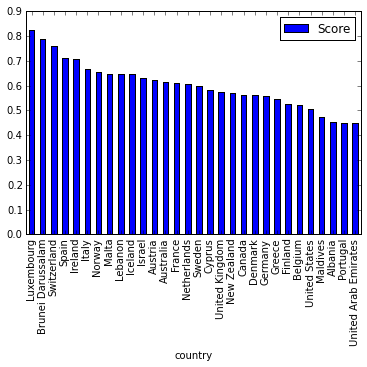

In [8]:
#PLOT RESULTS
dataToPlot = pd.DataFrame(list(dff['Preference Score']), index = dff.index, columns = ['Score'])
dataToPlot = dataToPlot.sort_values('Score', ascending=False)
dataToPlot.iloc[:30].plot(kind='bar')


In [16]:
#PLOT IN BROWSER

import plotly.graph_objs as go
import plotly.plotly as py

firstX = 30
dataToPlot = dataToPlot.iloc[:firstX][:firstX]

data = [
    go.Bar(
        x = list(dataToPlot['Score']),
        y = list(dataToPlot.index),
        orientation = 'h',
    )
]
plot_url = py.plot(data, filename='country-recommender-horizontal-bar')